In [ ]:
#Se importan las librerias
import mne
import pandas as pd
import numpy as np
import os

In [131]:
def data_reading_txt(filename_eeg_txt):
    ''' Función encargada de leer los archivos de EEG en formato txt'''
    # Leemos txt con pandas
    raw_data = pd.read_csv(filename_eeg_txt, skiprows=4)
    # Obtenemos columnas de tiempo y triggers
    other = raw_data.iloc[:, 12:19].to_numpy()
    analog_channel = raw_data.iloc[:, 19:22].to_numpy()
    time = raw_data[' Timestamp'].to_numpy()
    time = time-time[0]
    # Obtenemos columnas de canales y convertimos a uV 
    raw_data_eeg = raw_data.iloc[:, 1:9].to_numpy()*2.235174e-8
    # Creamos el objeto info 
    ch_names = ['Ch1','Ch2','Ch3','Ch4','Ch5', 'Ch6', 'Ch7', 'Ch8'] 
    ch_types = ['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg']
    sfreq = 2000
    eeg_info = mne.create_info(ch_names, sfreq, ch_types)
    # Creamos el objeto raw
    eeg_data = mne.io.RawArray(np.transpose(raw_data_eeg), eeg_info)

    return eeg_data

In [ ]:
# almacenamos la senal en un dato de tipo raw
raw = data_reading_txt('C:\\Users\\lucas\\OneDrive\\Desktop\\Facultad\\TIF\\Senales\\Sin Musica\\Antonella Battauz\\eeg.txt')

Creating RawArray with float64 data, n_channels=8, n_times=1518264
    Range : 0 ... 1518263 =      0.000 ...   759.131 secs
Ready.


In [133]:
# Obtener los nombres actuales de los primeros 3 canales
canales_antiguos = raw.ch_names[:3]

# Definir los nuevos nombres según lo que ustedes registraron, si no son esos cambien el nombre
canales_nuevos = ['Fz', 'Cz', 'Pz']

# Crear un diccionario {antiguo: nuevo}
rename_dict = dict(zip(canales_antiguos, canales_nuevos))

# Renombrar
raw.rename_channels(rename_dict)

<RawArray | 8 x 1518264 (759.1 s), ~92.7 MiB, data loaded>

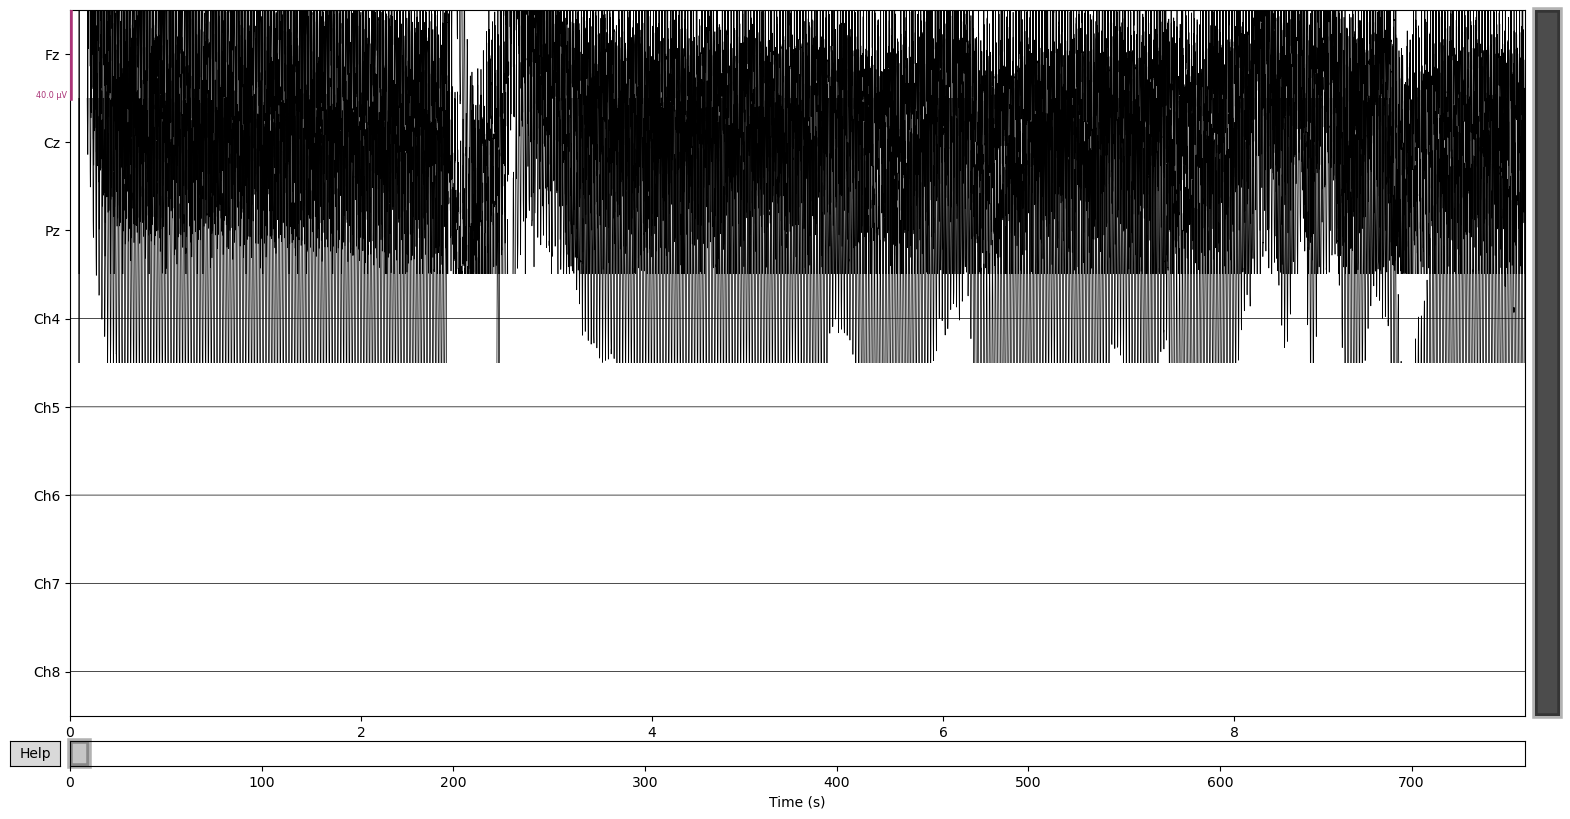

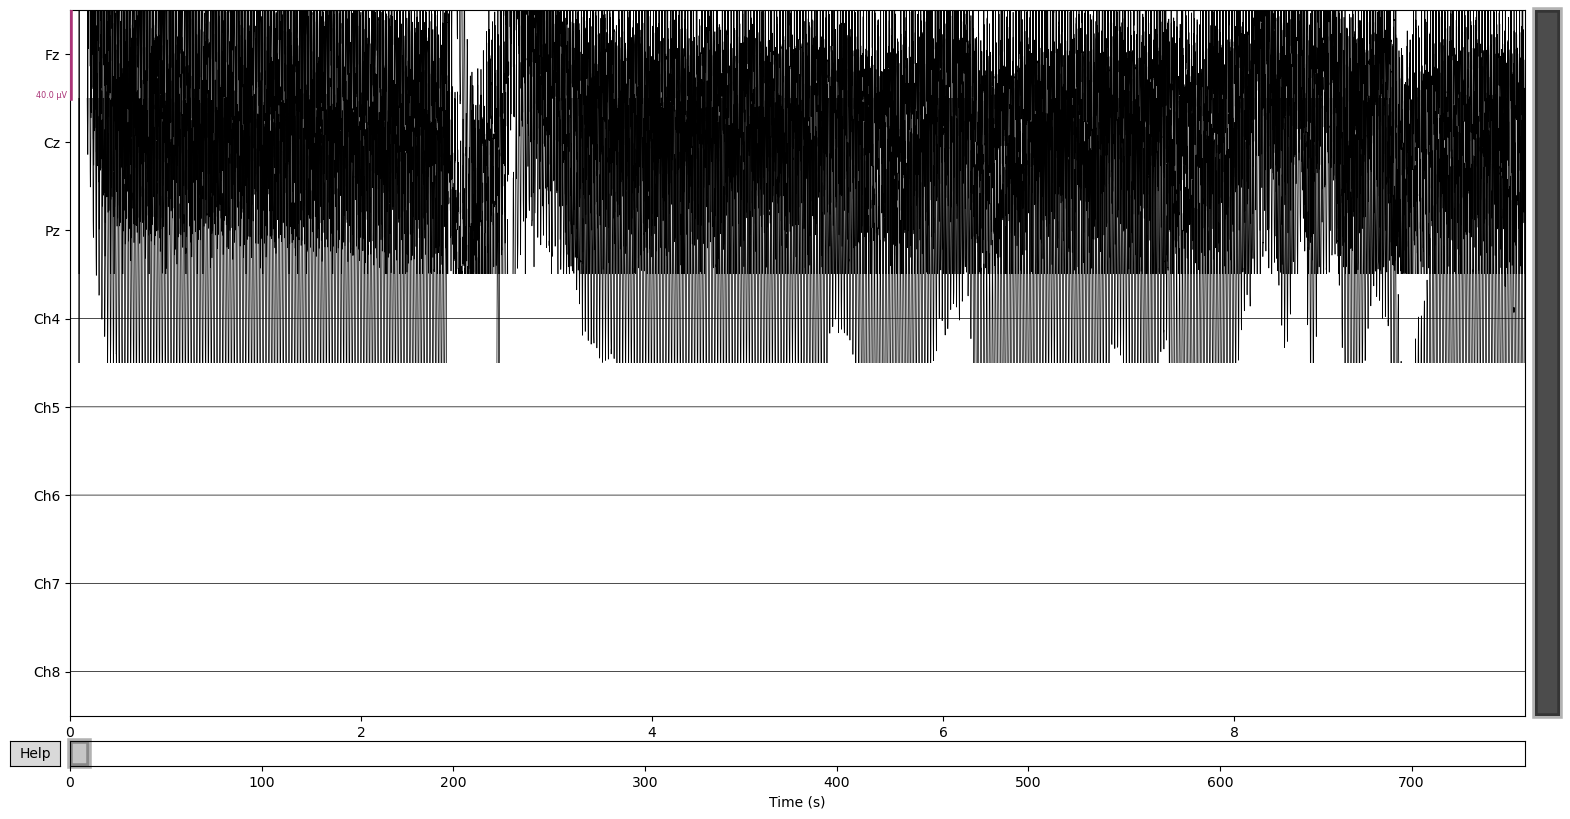

In [134]:
# grafico la señal para verla
raw.plot()

In [135]:
# acá me fijé cuánto dura la señal
duracion_total = raw.times[-1]  # en segundos
duracion_total

759.1315

In [136]:
from scipy.signal import medfilt 
data = raw.get_data().T
filtrada = data.copy()
filtered = medfilt(data, kernel_size=3)
raw = mne.io.RawArray(filtrada.T, raw.info)

Creating RawArray with float64 data, n_channels=8, n_times=1518264
    Range : 0 ... 1518263 =      0.000 ...   759.131 secs
Ready.


In [137]:
# #Filtro de valores vecinos

# data = raw.get_data().T  # (n_muestras, n_canales)
# promedio_canal = np.mean(data, axis=0)

# # Copiamos los datos para no modificar el original
# filtrada = data.copy()

# for ch in range(data.shape[1]):  # recorrer canales
#     for i in range(data.shape[0]):
#         if data[i, ch] > promedio_canal[ch]:
#             if i == 0:
#                 filtrada[i, ch] = promedio_canal[ch]
#             elif i == data.shape[0] - 1:
#                 filtrada[i, ch] = (data[i - 1, ch] + data[i, ch]) / 2
#             else:
#                 filtrada[i, ch] = (data[i - 1, ch] + data[i + 1, ch]) / 2

In [138]:
raw = mne.io.RawArray(filtrada.T, raw.info)

Creating RawArray with float64 data, n_channels=8, n_times=1518264
    Range : 0 ... 1518263 =      0.000 ...   759.131 secs
Ready.


In [139]:
# Cargar el archivo CSV
df = pd.read_csv("C:\\Users\\lucas\\OneDrive\\Desktop\\Facultad\\TIF\\Senales\\Sin Musica\\Antonella Battauz\\sart.csv")

In [140]:
df_filtered = df[df["thisN"].isin([0, 134])].copy()

# Localizamos la segunda aparición de thisTrialN == 0
idx_0 = df_filtered.index[df_filtered["thisN"] == 0]
if len(idx_0) >= 2:
    second_0_index = idx_0[1]  # segunda ocurrencia
else:
    raise ValueError("Solo se encontró una ocurrencia de thisN == 0")

# Extraemos esa fila y la que tiene thisTrialN == 134
row_second_0 = df_filtered.loc[second_0_index]
row_134 = df_filtered[df_filtered["thisN"] == 134].iloc[0]

# Unimos ambas en un nuevo DataFrame
result = pd.DataFrame([row_second_0, row_134])

if "trial_4.stopped" in df.columns:
    trial4_value = df["trial_4.stopped"].dropna().iloc[0]  # toma el primero no vacío

In [ ]:
#se calcula el tiempo de duracion de la prueba
t_cruz=0.9
t_numero=0.25
t_prueba=(t_cruz+t_numero)*134
t_prueba

154.1

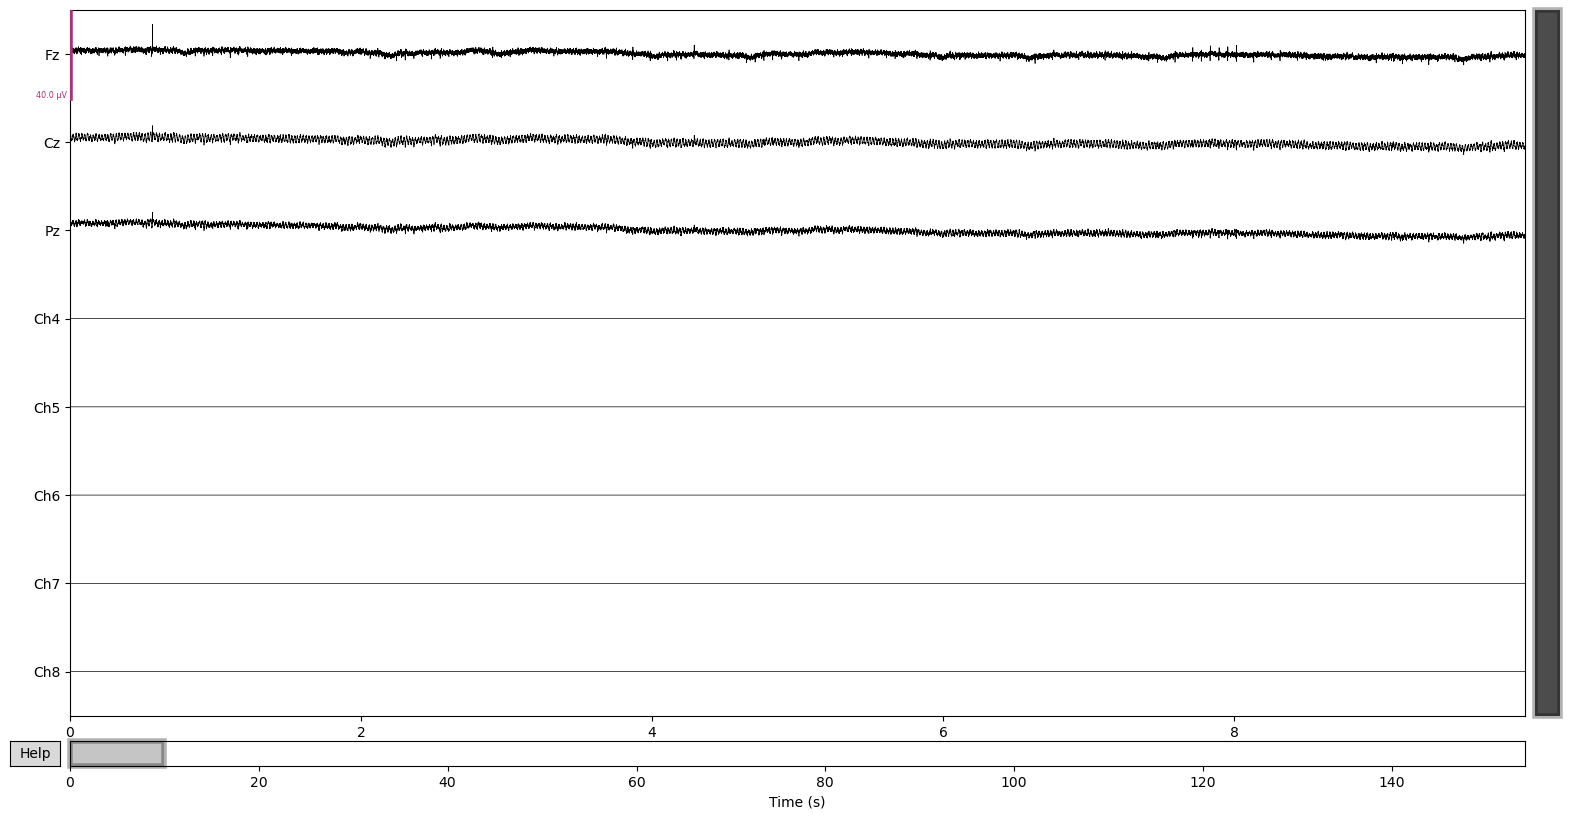

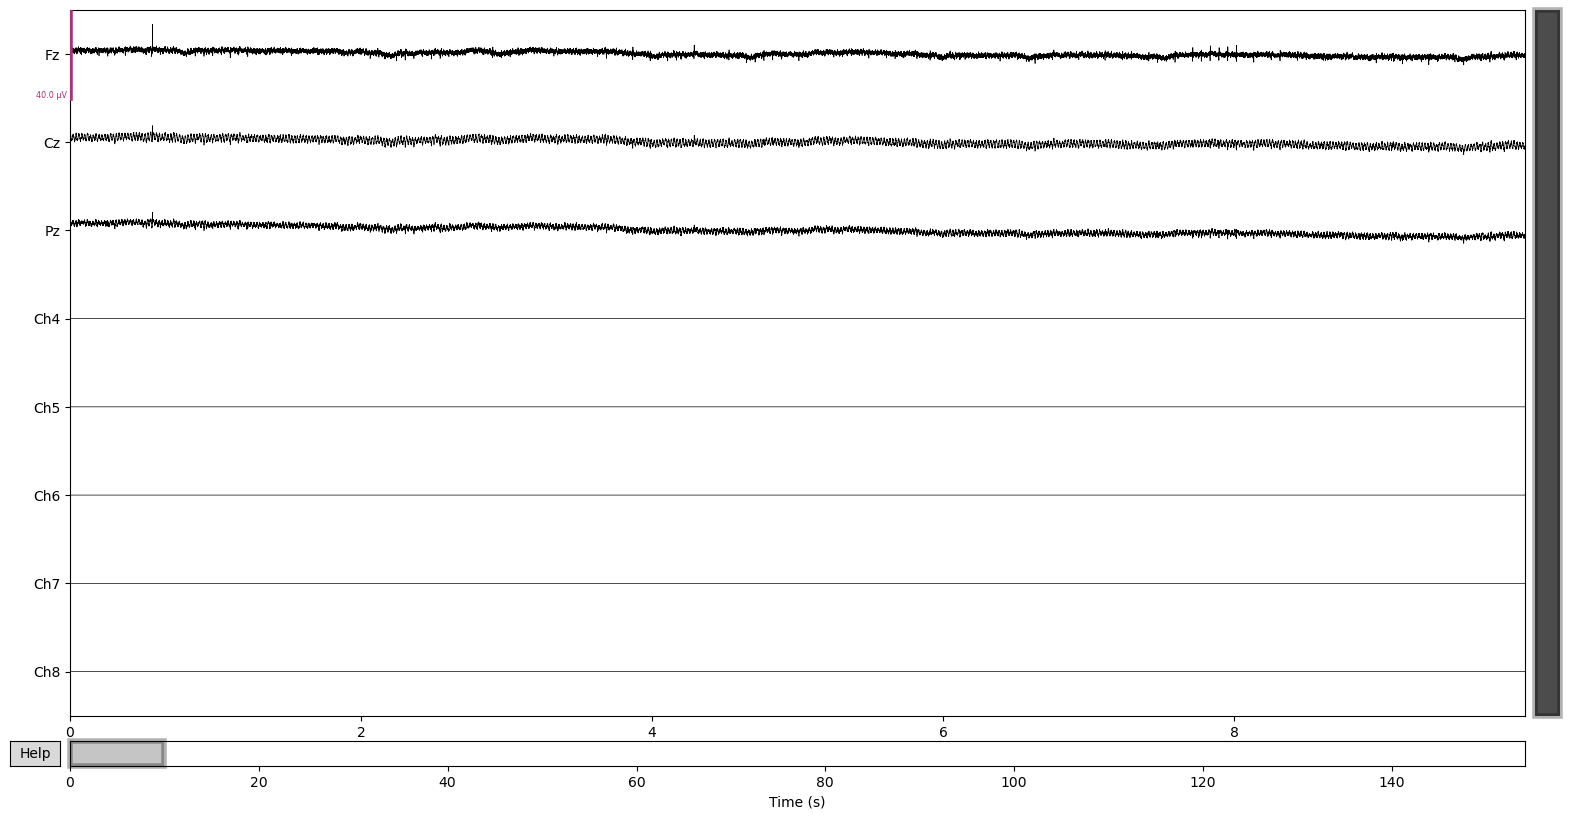

In [ ]:
# Acá voy a cortar la señal desde el final hacia atrás aprox. 2 minutos, creo que la tarea duraba aprox. 2 minutos y parece que se realizó hacia el 
# final del registro, por eso se corta esa sección de la señal
t_inicio = max(duracion_total - 154, 0)  # 154 segundos hacia atrás
raw_ultimos_2min = raw.copy().crop(tmin=t_inicio, tmax=duracion_total)
raw_ultimos_2min.plot()

## Razón theta/beta

In [143]:
# Seleccionar los canales
canales = ['Fz', 'Cz', 'Pz'] # Son los 3 canales que utilizan
raw_sel = raw_ultimos_2min.copy().pick_channels(canales)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [144]:
# Obtener los datos como array (shape: n_channels x n_times)
data = raw_sel.get_data()  # por defecto en Voltios
sfreq = raw_sel.info['sfreq']

Espectro de potencia de la señal de eeg

Effective window size : 1.000 (s)


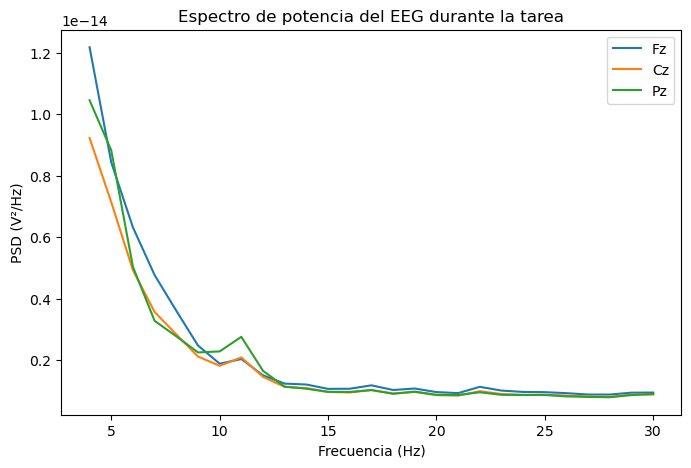

In [145]:
from mne.time_frequency import psd_array_welch
import matplotlib.pyplot as plt 

# Parámetros para ventanas de 1 s con 50% de solapamiento
n_fft = int(sfreq * 1.0)       # 1 s
noverlap = int(sfreq * 0.5)    # 0.5 s

# Calcular PSD
psd, freqs = psd_array_welch(
    data, sfreq=sfreq, fmin=4, fmax=30,
    n_fft=n_fft, n_overlap=noverlap
)

# Graficar
plt.figure(figsize=(8,5))
for i, ch_name in enumerate(canales):
    plt.plot(freqs, psd[i], label=ch_name)
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("PSD (V²/Hz)")
plt.title("Espectro de potencia del EEG durante la tarea")
plt.legend()
plt.show()

Obtenemos potencia en las bandas theta (4-8 Hz) y beta (13-30 Hz)

In [146]:
theta_band = (4, 8)
beta_band  = (13, 30)
theta_idx = (freqs >= theta_band[0]) & (freqs <= theta_band[1])
beta_idx  = (freqs >= beta_band[0])  & (freqs <= beta_band[1])

In [147]:
theta_power = np.mean(psd[:, theta_idx], axis=1)  # promedio sobre frecuencias
beta_power  = np.mean(psd[:, beta_idx], axis=1)

In [148]:
theta_beta_ratio = theta_power / beta_power

for ch, ratio in zip(['Fz','Cz','Pz'], theta_beta_ratio):
    print(f"Canal {ch}: Theta/Beta = {ratio:.3f}")

Canal Fz: Theta/Beta = 6.894
Canal Cz: Theta/Beta = 5.985
Canal Pz: Theta/Beta = 6.596


In [149]:
# Promedio sobre los 3 canales
theta_power_mean = np.mean(theta_power)
beta_power_mean  = np.mean(beta_power)

# Razón theta/beta promedio
theta_beta_ratio_mean = theta_power_mean / beta_power_mean

print(f"Potencia theta promedio de Fz, Cz y Pz: {theta_power_mean}")
print(f"Potencia beta promedio de Fz, Cz y Pz: {beta_power_mean:}")
print(f"Razón theta/beta promedio de Fz, Cz y Pz: {theta_beta_ratio_mean:.3f}")

Potencia theta promedio de Fz, Cz y Pz: 6.2223146699651945e-15
Potencia beta promedio de Fz, Cz y Pz: 9.565291469343788e-16
Razón theta/beta promedio de Fz, Cz y Pz: 6.505
